In [47]:
#0. CASO 5: CARGAR LIBRERIAS
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pycaret.classification import *
import shap

In [48]:
#1. CARGAR DE DATOS
df = pd.read_csv("taller2_MLE.csv")

In [49]:
df.head()

,edad,segmento,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,rango_ingresos,region,cerrara_cuenta
0,48,Preferente,43791.80,5,11,0,1,1,4.2,36.82,Medio,Sierra,0
1,36,Estándar,17940.87,1,7,0,1,0,2.2,39.78,Muy Alto,Selva,0
2,48,Estándar,9308.09,4,3,0,1,1,1.0,28.36,Medio,Sierra,1
3,30,Estándar,709.76,5,5,1,1,0,5.0,45.73,Bajo,Selva,0
4,74,Preferente,20471.46,1,4,0,0,1,3.1,39.19,Medio,Sierra,0


In [50]:
df.describe()

,edad,saldo_total,numero_productos,visitas_app_mes,usa_web,usa_tarjeta_credito,reclamos_6m,satisfaccion_encuesta,tasa_credito_personal,cerrara_cuenta
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000
mean,46.141000,20416.034312,2.987800,6.047000,0.699000,0.612400,0.489000,3.018240,34.986158,0.140400
std,16.357733,13588.538852,1.420583,2.484195,0.458739,0.487251,0.700555,1.145849,8.156743,0.347436
min,18.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,10.000000,0.000000
25%,32.000000,9780.610000,2.000000,4.000000,0.000000,0.000000,0.000000,2.000000,29.570000,0.000000
50%,46.000000,19784.830000,3.000000,6.000000,1.000000,1.000000,0.000000,3.000000,35.120000,0.000000
75%,60.000000,29887.305000,4.000000,8.000000,1.000000,1.000000,1.000000,4.000000,40.490000,0.000000
max,74.000000,66416.670000,5.000000,17.000000,1.000000,1.000000,6.000000,5.000000,65.040000,1.000000


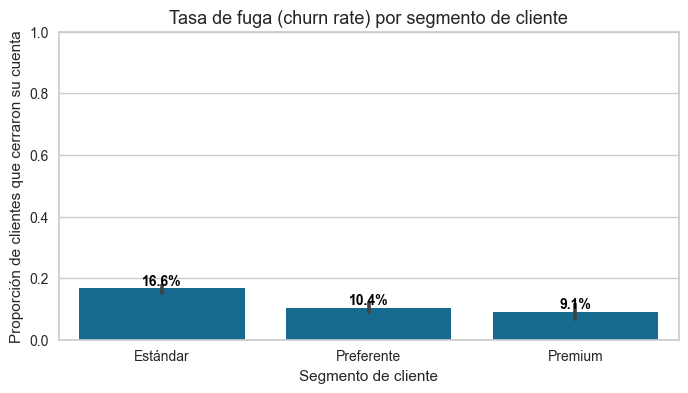

In [51]:
#2.ANALISIS EXPLORATORIO; CTR por plataforma
# Crear columna auxiliar de churn (para claridad visual)
df['tasa_fuga'] = df['cerrara_cuenta']

plt.figure(figsize=(8,4))
ax = sns.barplot(data=df, x='segmento', y='tasa_fuga', estimator=lambda x: sum(x)/len(x), order=df.groupby('segmento')['cerrara_cuenta'].mean().sort_values(ascending=False).index)

# Agregar etiquetas de porcentaje sobre cada barra
for p in ax.patches:
    ax.annotate(f'{p.get_height()*100:.1f}%', 
                (p.get_x() + p.get_width() / 2., p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black', fontweight='bold')

plt.title("Tasa de fuga (churn rate) por segmento de cliente", fontsize=13)
plt.ylabel("Proporción de clientes que cerraron su cuenta")
plt.xlabel("Segmento de cliente")
plt.ylim(0, 1)
plt.show()


Text(0.5, 1.0, 'Tasa de fuga por rango de ingresos')

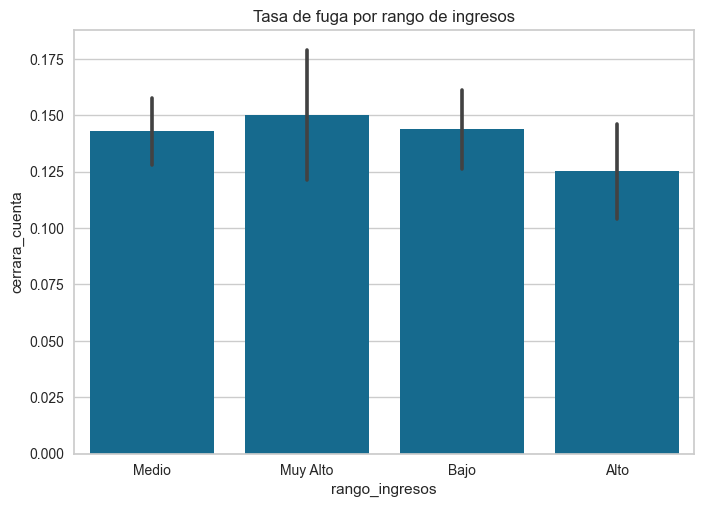

In [52]:
sns.barplot(data=df, x='rango_ingresos', y='cerrara_cuenta')
plt.title("Tasa de fuga por rango de ingresos")


In [53]:
#3.FEATURE ENGINEERING: ENGAGEMENT COMBINADO
# Normalizar variables (0 a 1)
df['prod_norm'] = (df['numero_productos'] - df['numero_productos'].min()) / (df['numero_productos'].max() - df['numero_productos'].min())
df['visitas_norm'] = (df['visitas_app_mes'] - df['visitas_app_mes'].min()) / (df['visitas_app_mes'].max() - df['visitas_app_mes'].min())

# Crear indicador de engagement combinado
df['engagement'] = np.sqrt(df['prod_norm']*0.6 + df['visitas_norm']*1.4 + df['usa_web']*0.3 + df['usa_tarjeta_credito']*0.3)


In [54]:
# Categorizar por uso digital
df['uso_app_categoria'] = pd.cut(
    df['visitas_app_mes'],
    bins=[0, 5, 20, 60],
    labels=['Bajo uso', 'Uso medio', 'Uso alto']
)


In [55]:
# Convertir el canal digital a texto según su uso
df['canal_digital'] = np.where(
    (df['uso_app_categoria'] == 'Bajo uso') & (df['usa_web'] == 0), 'Offline',
    np.where((df['uso_app_categoria'] == 'Bajo uso') & (df['usa_web'] == 1), 'Web',
    np.where((df['uso_app_categoria'] == 'Uso medio') | (df['uso_app_categoria'] == 'Uso alto'), 'App', 'Otro'))
)

# Crear la variable combinada de canal y segmento
df['canal_segmento'] = df['canal_digital'] + "_" + df['segmento']


In [56]:
cols_cat = ['segmento', 'rango_ingresos', 'region', 'uso_app_categoria', 'canal_segmento']

# Forzar a tipo 'object' (PyCaret los detecta mejor así que 'category')
df[cols_cat] = df[cols_cat].astype(str)

# Confirmar
print(df[cols_cat].dtypes)


segmento             object
rango_ingresos       object
region               object
uso_app_categoria    object
canal_segmento       object
dtype: object


In [57]:
# Convertir todas las columnas object a category
obj_cols = df.select_dtypes(include='object').columns
df[obj_cols] = df[obj_cols].astype('category')

print("Columnas convertidas a categoría:", obj_cols.tolist())


Columnas convertidas a categoría: ['segmento', 'rango_ingresos', 'region', 'uso_app_categoria', 'canal_digital', 'canal_segmento']


In [58]:
from pycaret.classification import setup

clf = setup(
    data=df,
    target='cerrara_cuenta',
    session_id=2025,
    categorical_features=['segmento', 'rango_ingresos', 'region', 'uso_app_categoria', 'canal_digital', 'canal_segmento'],
    ignore_features=['tasa_fuga', 'prod_norm', 'visitas_norm'],  # o ajusta según tu análisis
    normalize=True,
    transformation=True,
    transformation_method='yeo-johnson',
    fix_imbalance=True
)


,Description,Value
0,Session id,2025
1,Target,cerrara_cuenta
2,Target type,Binary
3,Original data shape,"(5000, 20)"
4,Transformed data shape,"(7518, 40)"
5,Transformed train set shape,"(6018, 40)"
6,Transformed test set shape,"(1500, 40)"
7,Ignore features,3
8,Numeric features,10
9,Categorical features,6


In [59]:
# Comparar modelos automáticamente
best_model = compare_models()

,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
dummy,Dummy Classifier,0.8597,0.5000,0.0000,0.0000,0.0000,0.0000,0.0000,0.0750
ridge,Ridge Classifier,0.8591,0.6229,0.0183,0.4250,0.0346,0.0242,0.0635,0.0720
lda,Linear Discriminant Analysis,0.8589,0.6227,0.0183,0.4250,0.0346,0.0236,0.0628,0.0900
gbc,Gradient Boosting Classifier,0.8583,0.6116,0.0000,0.0000,0.0000,-0.0028,-0.0108,0.3100
lr,Logistic Regression,0.8574,0.6274,0.0102,0.2417,0.0193,0.0097,0.0268,0.7330
rf,Random Forest Classifier,0.8574,0.6118,0.0122,0.2083,0.0231,0.0125,0.0262,0.1960
ada,Ada Boost Classifier,0.8569,0.6234,0.0082,0.1667,0.0155,0.0058,0.0126,0.1490
lightgbm,Light Gradient Boosting Machine,0.8517,0.5872,0.0265,0.2184,0.0467,0.0201,0.0322,0.2900
et,Extra Trees Classifier,0.8511,0.5861,0.0265,0.2025,0.0465,0.0191,0.0293,0.1960
svm,SVM - Linear Kernel,0.8489,0.5424,0.0243,0.1459,0.0390,0.0121,0.0168,0.0830


In [62]:
gbc_model = create_model('gbc')

,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8600,0.6049,0.0000,0.0000,0.0000,0.0000,0.0000
1,0.8571,0.6854,0.0000,0.0000,0.0000,-0.0056,-0.0216
2,0.8600,0.6002,0.0000,0.0000,0.0000,0.0000,0.0000
3,0.8600,0.5866,0.0000,0.0000,0.0000,0.0000,0.0000
4,0.8571,0.6418,0.0000,0.0000,0.0000,-0.0056,-0.0216
5,0.8571,0.6035,0.0000,0.0000,0.0000,-0.0056,-0.0216
6,0.8600,0.5779,0.0000,0.0000,0.0000,0.0000,0.0000
7,0.8600,0.5813,0.0000,0.0000,0.0000,0.0000,0.0000
8,0.8571,0.6312,0.0000,0.0000,0.0000,-0.0056,-0.0216


In [63]:
# 🔍 Interpretar con SHAP manualmente
X_train_transformed = get_config('X_train_transformed')
explainer = shap.TreeExplainer(gbc_model)
shap_values = explainer.shap_values(X_train_transformed)

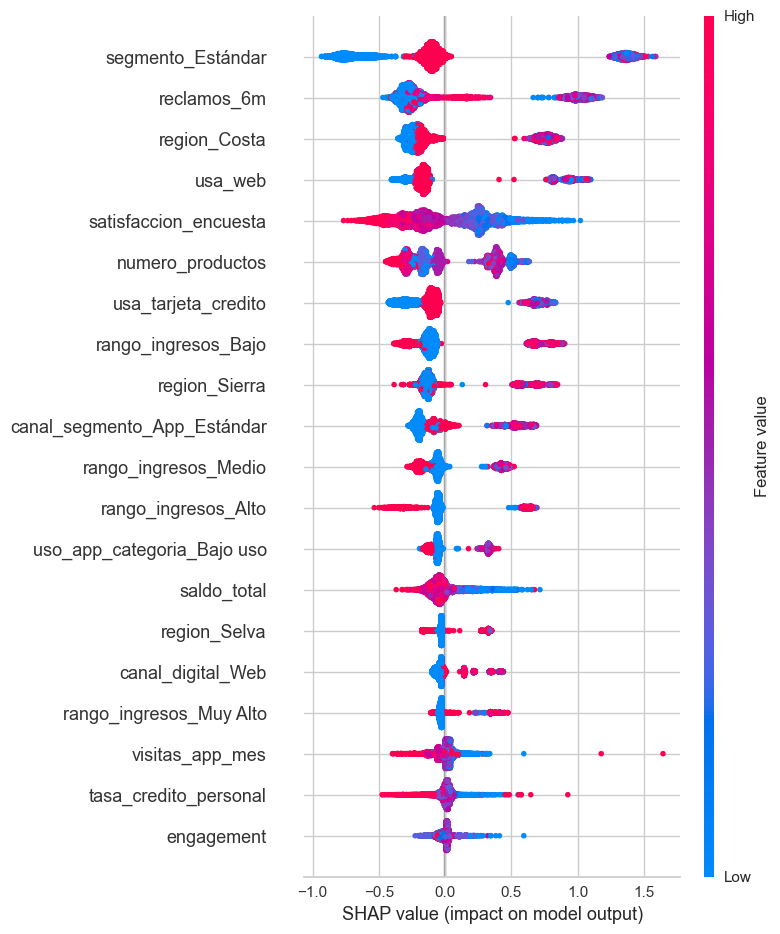

In [64]:
# Detectar si shap_values es una lista (por clase) o una matriz única
if isinstance(shap_values, list):
    # Modelo binario: usar la matriz de la clase positiva
    shap_matrix = shap_values[1]
else:
    # Modelo binario con una sola matriz
    shap_matrix = shap_values

# Ajustar si hay columna extra (offset)
if shap_matrix.shape[1] == X_train_transformed.shape[1] + 1:
    shap_values_fixed = shap_matrix[:, :-1]
else:
    shap_values_fixed = shap_matrix

# Alinear filas si hay desajuste
min_rows = min(shap_values_fixed.shape[0], X_train_transformed.shape[0])
shap.summary_plot(shap_values_fixed[:min_rows], X_train_transformed.iloc[:min_rows])